In [119]:
import numpy as np
import matplotlib.pyplot as plt
import hmms
from pprint import pformat

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [170]:
# My experiment for prediction of emmission states within STATE 2
#(as state2 consists of several node transition in a unidirectional way): 


#STEP 1: Create a model of sequences with prior known(randomly generated) transition matrix, 
        # emmision probability, and initial state prob.vector 

'''
# Previous method for topomap - by Abhishesh

# defining a very simple topological map (a circle) of N_nodes states
# we can go form 1->2, 2->3 etc only
topo_map=np.eye(N_nodes, k=1) # create identity matrix with N_nodes rows with diagonal element as 1.
topo_map[-1,1] = 1                 # replace last row, first column element with 1
topo_map[2,0] = 0.142
topo_map[2,-2] = 0.857 
print (topo_map)
# this will add an unlikely movement in reverse direction:
topo_map+=np.eye(N_nodes, k=-1) * .1    # update topomap with identity matrix with diagonal element as -1 * .1            
topo_map[0,-1] = .1                     # update first row and last column as .1
print (topo_map)
'''

'''
Revised method for topomap - by Abhishesh

# defining a very simple topological map (a circle) of N_nodes states
# we can go form 1->2, 2->3 etc only
topo_map=np.eye(N_nodes, k=0)   # create identity matrix with N_nodes rows with diagonal element as 1.
print('topo1: %s' % topo_map)
topo_map[-1,1] = 1                 # replace last row, first column element with 1
topo_map[2,0] = 0.142
topo_map[2,-2] = 0.857 
print (topo_map)
# this will add an unlikely movement in reverse direction:
topo_map+=np.eye(N_nodes, k=-1) * .1    # update topomap with identity matrix with diagonal element as -1 * .1            
topo_map[0,-1] = .1                     # update first row and last column as .1
print('topo2: %s' % topo_map)
'''

N_nodes = 5 #10
# expected mean rate in seconds

topo_map = np.eye(N_nodes, k=1) # connect all the successive nodes forward
topo_map += np.eye(N_nodes, k=-1)*0.1 # connect all the successive nodes reverse
topo_map[2,0] = 1    # 2 --> 0
topo_map[0,2] = 0.1  # 0 --> 2
topo_map[-1,1] = 1   # 4 --> 1
topo_map[1,-1] = 0.1 # 1 --> 4
print ('topo_map:\n', topo_map)

# summing all column of adjency matrix
#rs = np.sum(topo_map,1)       # it sums up all the columns of a single row, 
#print ('rs:\n', rs) #so that it can help in defining Q in next step

_rate = np.eye(N_nodes, k=1)
_rate[0,1] = 1/0.1
_rate[1,2] = 1/200.73
_rate[2,3] = 1/2139.717
_rate[3,4] = 1/281.700
_rate[4,1] = 1/110.100
print ('rate:\n', _rate)


#_Q1 = (np.diag(-rs) + topo_map)
#print ('Q1:\n', _Q1)
#_Q1 = (np.diag(-rs) + topo_map)
#print ('Q1:\n', _Q1)

#_Q2 = np.eye(5, k=1)*0
#print ('Q2:\n', _Q2)
_Q2 = topo_map
print ('Q2:\n', _Q2)
_Q2[0,:] = (1/0.1)
print ('Q0:\n', _Q2)
_Q2[1,:] += (1/200.73)
print ('Q1:\n', _Q2)
_Q2[2, :] += (1/2139.717)
print ('Q2:\n', _Q2)
_Q2[3, :] += (1/281.700)
print ('Q3:\n', _Q2)
_Q2[4, :] += (1/110.100)
_Q2[1, 1] = 0
_Q2[2, 2] = 0
_Q2[3, 3] = 0
_Q2[4, 4] = 0
_Q2[0, 0] = 0
_Q2[2, 0] = 0
_Q2[4, 1] = 0
_Q2[0, 2] = 0
_Q2[1, 4] = 0
print ('Q5:\n', _Q2)

rp = np.sum(_Q2,1)
print ('rp:\n', rp)
print (np.diag(-rp))
print (_Q2)
Q = (np.diag(-rp) + _Q2)
print (len(Q))
print ('Q:\n', Q) 

# creating the transition rate matrix (https://en.wikipedia.org/wiki/Transition_rate_matrix)
#Q = np.multiply(Q1,(ts))
#Q = Q1 * np.diag(-ts)
#Q += np.eye(N_nodes, k=0)*0
#print (len(Q))
#print ('Q:\n', Q) 
#Q = (np.diag(-rs) + topo_map) * _lambda   # Keep in mind that, sum(Qij) = -Qii =< 1.  



#_rate = 0.346
#_lambda = 1.0/_rate

#-----------------------------------

# creating observation matrix, assuming each states has ~70% prob to emit the state itself as observation
# and another ~10% for neighbouring states each (confusing them). and +.1% for all observations
# for numerical stability
B_pre = np.ones(N_nodes) * .001 + np.eye(N_nodes) * .7 + np.eye(N_nodes, k=1) * .1 + np.eye(N_nodes, k=-1) * .1
print (len(B))
print ('B:\n', B)
# adding 10% change of "unknown" observation which each state is equally likely to emit (used for prediction)
# This assumption can be eliminated 

B = np.transpose(np.vstack([B_pre, [.101] * N_nodes]))  # np.vstack will add extra column in B_pre matrix
                                                        # vertically
B[0,-2] = .101     # first row and second last column is filled with 0.101
B[-1,0] = .101     # Last row and first columm is filled with 0.101


# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]

# Pi is the vector of initial state probabilities. Assuming uniform here
# (We may make a stronger assumption here at some point)
Pi = np.array( [1.0 / N_nodes] * N_nodes ) # We need to change Pi based on des data as Pi = [0.03, 0.26, 0.23, 0.23, 0.23]
print (len(Pi))
print ('Pi:\n', Pi)

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)
print('_Q=%s,\nB=%s,\nPi=%s' % chmm.params)
#chmm.save_params("allstate_cthmm")
#chmm_from_file = hmms.CtHMM.from_file( "allstate_cthmm.npz" )

#Set & Get Parameters:Later you can always set parameters with triple of methods corresponding to the constructors.
# chmm.set_params(Q,B,Pi)
# chmm.set_params_random(3,3)
# chmm.set_params_from_file( "state2_cthmm.npz" )

topo_map:
 [[0.  1.  0.1 0.  0. ]
 [0.1 0.  1.  0.  0.1]
 [1.  0.1 0.  1.  0. ]
 [0.  0.  0.1 0.  1. ]
 [0.  1.  0.  0.1 0. ]]
rate:
 [[0.00000000e+00 1.00000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.98181637e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.67351524e-04
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.54987575e-03]
 [0.00000000e+00 9.08265213e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
Q2:
 [[0.  1.  0.1 0.  0. ]
 [0.1 0.  1.  0.  0.1]
 [1.  0.1 0.  1.  0. ]
 [0.  0.  0.1 0.  1. ]
 [0.  1.  0.  0.1 0. ]]
Q0:
 [[10.  10.  10.  10.  10. ]
 [ 0.1  0.   1.   0.   0.1]
 [ 1.   0.1  0.   1.   0. ]
 [ 0.   0.   0.1  0.   1. ]
 [ 0.   1.   0.   0.1  0. ]]
Q1:
 [[1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01]
 [1.04981816e-01 4.98181637e-03 1.00498182e+00 4.98181637e-03
  1.04981816e-01]
 [1.00000000e+00 1.00000000e-01 0

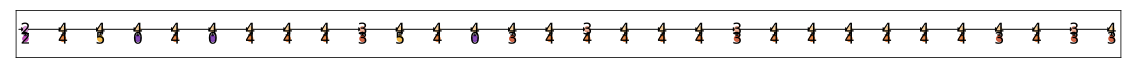

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116.]


In [179]:
# sample a random sequence within desired time peroiod from the above created model(for testing and generation)

# sample length (seconds)
sample_len = 120

# sample step (s)
sample_step = 4

# sample uniformly
t_seq = range(0,sample_len, sample_step)
t_seq, s_seq, e_seq = chmm.generate( len(t_seq), time=t_seq)

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )
print(t_seq)

[0 1 2] [1 5]


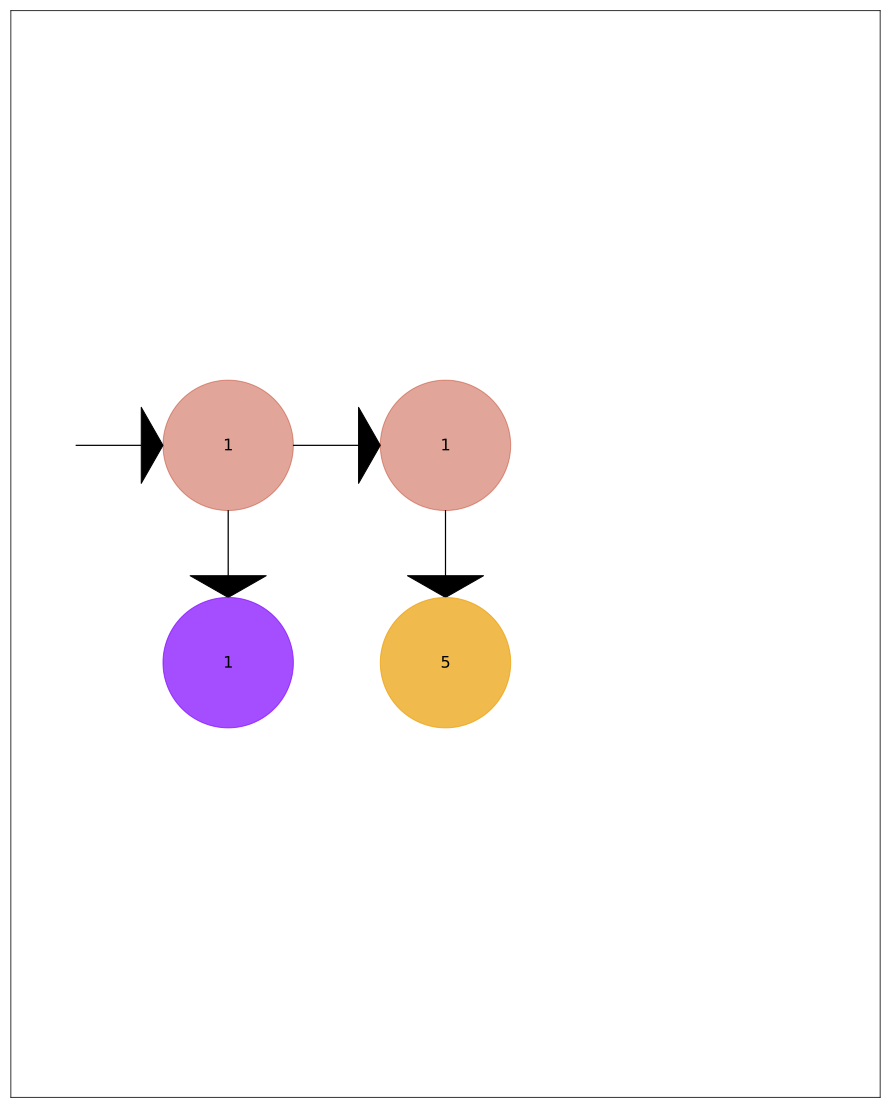

found state sequence: 
 [1 1]
predicted state looking 1.200000 seconds into the future: 1
Probability of being generated by the found state sequence: 0.004999634772734595
state probs: 
 [0.00113901 0.29477216 0.32718634 0.20843097 0.16847153]
Kullback–Leibler divergence (high is good in this case, as I compare against uniform): 0.249201


In [177]:
# now let's try some prediction, define the predict function
# we will take n observation states 
def predict(obs=np.array([1,2]), predict_time=20.0, verbose=False):

    # observations so far (this is where we have seen people being in a place at a specific time):
    e_seq = np.array(obs)
    # assume the observations were made 1 second apart
    t_seq = np.array(range(0,len(e_seq)+1))

    # Now the predict step 
    # the last observation codes for unknown,"abusing" the Viterbi algorithm to provide predictions 
    # purely on the transition model
    e_seq[-1:]=N_nodes 

    # this is the look ahead time (i.e. the time we look into the future based on the last observation)
    predict_time = 1.2

    # set the last "unknown" observation time:
    t_seq[-1] = t_seq[-2] + predict_time

    print(t_seq, e_seq)

    # run Viterbi algorithm for the CtHMM
    (log_prob, s_seq) =  chmm.viterbi( t_seq, e_seq )

    # We can also query the state distribution for the entire sequence
    log_prob_table = chmm.states_confidence( t_seq, e_seq )
    post_distribution = np.exp( log_prob_table[-1] )

    if verbose:
        # Let's print the most likely state sequence
        hmms.plot_hmm( s_seq, e_seq, time = t_seq )
        print( "found state sequence: \n", s_seq )
        print( "predicted state looking %f seconds into the future: %d" % (predict_time, s_seq[-1]) )
        print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )
        print( "state probs: \n", post_distribution)

    uniform = np.array([1.0 / N_nodes] * N_nodes)   # get the 1 X N_nodes matrix of uniform distribution

    # Now KL divergence is used to get the difference between the two distributions-- 
    # (here btween uniform and post_distribution) and is denoted by D_KL = (post_distribution || uniform) = 
    # itergral of (p(x)* log((px)/q(x))
    # KL divergence: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Basic_example
    # KL can be used here as a measure of certainty to some extend, used to compare against uniform distribution,
    # the longer into the future the prediction, the closer KL is to 0
    D_KL = np.sum(np.multiply(post_distribution, np.log(np.divide(post_distribution, uniform))))
    if verbose:
        print("Kullback–Leibler divergence (high is good in this case, as I compare against uniform): %f" % D_KL)

    return (s_seq[-1], D_KL, post_distribution)
    
    #for i in range(0,len(uniform)):


(state, KL, posteriors) = predict(
# start with some observations assumed to have made up to a point
obs=np.array([1,2]),
# the time horizon to predict to
predict_time=60,
# we want to see stuff here
verbose=True
)

[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2] [1 5]
[0 1 2

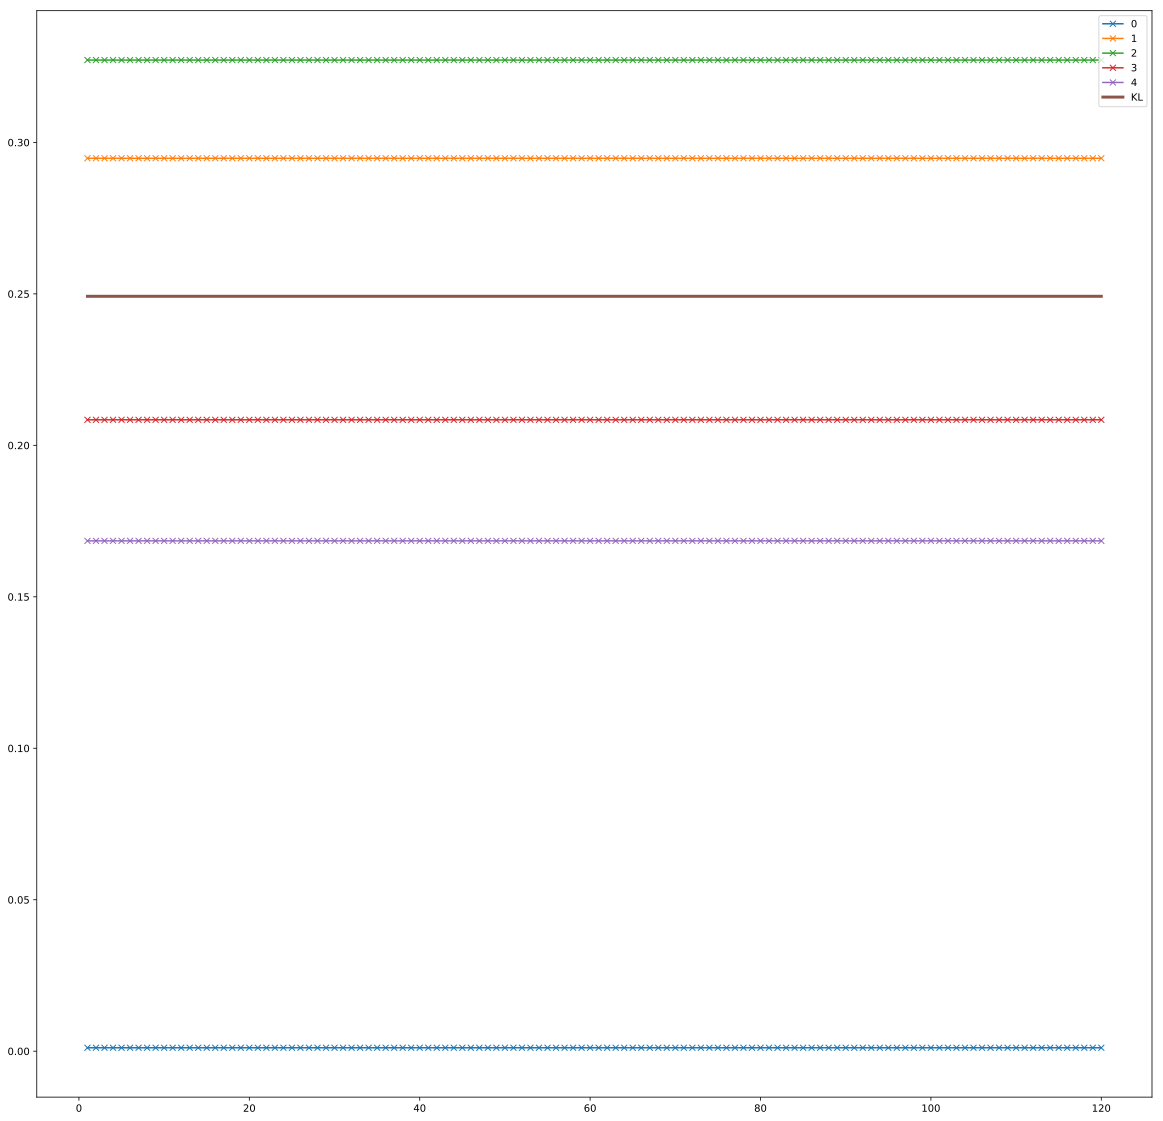

In [180]:
# now some iterations:

# forecast max seconds
forecast_max = 120
forecast_steps = 120

posteriors = []
states = {}
kls = []
times = []
bars = []

# try forecasting for several time steps:
for i in np.linspace(1, forecast_max, forecast_steps):  # Return evenly spaced numbers over a specified interval (start,stop, Num = int).
    (state, kl, posterior) = predict(
        obs = [1,2],
        predict_time = i,
        verbose = False
    )
    times.append(i)
    posteriors.append(posterior)
    states[i] = state
    kls.append(kl)

# plot the posterior probabilities
plt.plot(times, posteriors, '-x')

# plot the KL divergence (certainty)
plt.plot(times, kls, linewidth=3)

legend = list(range(0, N_nodes))
legend.append('KL')
plt.legend(legend)
print('state predictions:\n%s' % pformat(states))